## Filter Methods - Basics - Plus - Filter statistical tests

### Putting it all together

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    f_classif,
    SelectKBest,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load the Santander customer satisfaction dataset from Kaggle

data = pd.read_csv('../Data/dataset_1.csv')
data.shape

(50000, 301)

In [3]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

In [4]:
# I keep a copy of the dataset with all the variables
# to compare the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [6]:
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 266), (15000, 266))

### Remove quasi-constant features

In [7]:
sel = VarianceThreshold(threshold=0.01)

sel.fit(X_train) # finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

215

In [8]:
# previously, we captured the feature names like this:

features_to_keep = X_train.columns[sel.get_support()]

len(features_to_keep)

215

In [9]:
# now, we can also capture them like this:

features_to_keep = sel.get_feature_names_out()

len(features_to_keep)

215

<font color="green"># omd</font> 

Certainly! `VarianceThreshold` from scikit-learn is a simple feature selection technique that removes features whose variance doesn't meet a certain threshold. This is particularly useful when you have many features and want to remove those that are almost constant, as they typically don't contribute much to the model's performance. Here's an example of how to use `VarianceThreshold`:

```python
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# Create a sample DataFrame with features
data = {
    'feature1': [0, 1, 2, 3],
    'feature2': [0, 0, 0, 0],
    'feature3': [1, 1, 1, 1]
}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)

# Apply VarianceThreshold to remove features with low variance
threshold = 0.1  # Set the threshold for variance
selector = VarianceThreshold(threshold=threshold)
df_selected = selector.fit_transform(df)

# Get the mask of selected features
mask = selector.get_support()

# Get the names of selected features
selected_features = df.columns[mask]

print("\nSelected Features:")
print(selected_features)

# Transform the selected features back to DataFrame
df_selected = pd.DataFrame(df_selected, columns=selected_features)
print("\nDataFrame after feature selection:")
print(df_selected)
```

In this example, we have a DataFrame `df` with three features. `feature2` has very low variance (it's essentially constant), while `feature1` and `feature3` have higher variance. We apply `VarianceThreshold` with a threshold of `0.1` to remove features with variance less than this threshold. Finally, we print out the selected features and the DataFrame after feature selection.

Remember to adjust the threshold value according to your specific dataset and requirements.

In [17]:
# omd

# from sklearn.feature_selection import VarianceThreshold
# import pandas as pd

# Create a sample DataFrame with features
data = {
    'feature1': [0, 1, 2, 3],
    'feature2': [0, 0, 0, 0],
    'feature3': [1, 1, 1, 1]
}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)

# Apply VarianceThreshold to remove features with low variance
threshold = 0.1  # Set the threshold for variance
selector = VarianceThreshold(threshold=threshold)
df_selected = selector.fit_transform(df)

# Get the mask of selected features
mask = selector.get_support()

# Get the names of selected features
selected_features = df.columns[mask]

print("\nSelected Features:")
print(selected_features)

# Transform the selected features back to DataFrame
df_selected = pd.DataFrame(df_selected, columns=selected_features)
print("\nDataFrame after feature selection:")
print(df_selected)


Original DataFrame:
   feature1  feature2  feature3
0         0         0         1
1         1         0         1
2         2         0         1
3         3         0         1

Selected Features:
Index(['feature1'], dtype='object')

DataFrame after feature selection:
   feature1
0         0
1         1
2         2
3         3


In [19]:
# remove the features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 215), (15000, 215))

In [20]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [21]:
# check for duplicated features in the training set

duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210


10

In [22]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 205), (15000, 205))

In [23]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

### Remove correlated features

In [24]:
# find and remove correlated features
def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(X_train, 0.8)
print('correlated features: ', len(set(corr_features)))

correlated features:  93


In [25]:
# remove correlated features

X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [26]:
# keep a copy of the dataset at  this stage

X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

### Select features based of anova

In [27]:
sel_ = SelectKBest(f_classif, k=20).fit(X_train, y_train)

# capture selected feature names
features_to_keep = X_train.columns[sel_.get_support()]

# or
features_to_keep = sel_.get_feature_names_out()

# ============

# select features
X_train_anova = sel_.transform(X_train)
X_test_anova = sel_.transform(X_test)

# numpy array to dataframe
X_train_anova = pd.DataFrame(X_train_anova)
X_train_anova.columns = features_to_keep

X_test_anova = pd.DataFrame(X_test_anova)
X_test_anova.columns = features_to_keep

X_train_anova.shape, X_test_anova.shape

((35000, 20), (15000, 20))

### Compare the performance in machine learning algorithms

In [28]:
# create a function to build random forests and
# compare its performance in train and test sets


def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [29]:
# original
run_randomForests(X_train_original,
                  X_test_original,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.807612232524249
Test set
Random Forests roc-auc: 0.7868832427636059


In [30]:
# filter methods - basic
run_randomForests(X_train_basic_filter,
                  X_test_basic_filter,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.810290026780428
Test set
Random Forests roc-auc: 0.7914020645941601


In [31]:
# filter methods - correlation
run_randomForests(X_train_corr,
                  X_test_corr,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8066004772684517
Test set
Random Forests roc-auc: 0.7859521124929707


In [32]:
# filter methods - univariate roc-auc
run_randomForests(X_train_anova,
                  X_test_anova,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8181634778452822
Test set
Random Forests roc-auc: 0.7994720109870546


As we see, the 20 features we selected using the univariate anova are doing a good job, as the final model does not show a decrease in performance compared to that one using all features.

In [33]:
# create a function to build logistic regression
# and compare its performance in train and test sets


def run_logistic(X_train, X_test, y_train, y_test):

    scaler = StandardScaler().fit(X_train)

    # function to train and test the performance of logistic regression
    logit = LogisticRegression(
        penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    
    # fit
    logit.fit(scaler.transform(X_train), y_train)

    print('Train set')
    pred = logit.predict_proba(scaler.transform(X_train))
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(scaler.transform(X_test))
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [34]:
# original
run_logistic(X_train_original,
             X_test_original,
             y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8022197599721129
Test set
Logistic Regression roc-auc: 0.795929816232469


In [35]:
# filter methods - basic

run_logistic(X_train_basic_filter,
             X_test_basic_filter,
             y_train, y_test)

Train set
Logistic Regression roc-auc: 0.801572922199813
Test set
Logistic Regression roc-auc: 0.7956276722308412


In [36]:
# filter methods - correlation

run_logistic(X_train_corr,
             X_test_corr,
             y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7938745217286656
Test set
Logistic Regression roc-auc: 0.7882478643347434


In [37]:
# filter methods - univariate anova

run_logistic(X_train_anova,
             X_test_anova,
             y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7827245834924114
Test set
Logistic Regression roc-auc: 0.7720492495853009


As we see, the 20 features we selected using the univariate anova are doing a good job, as the final model does not show a big decrease in performance compared to that one using all features.

Why don't you try to apply the univariate anova without removing features by correlation, to see if the selected features are good enough?

That is all for this lecture. I hope you enjoyed it!

In [93]:
from xgboost import XGBClassifier
from sklearn import metrics

model_xgb = XGBClassifier(n_estimator=300, learning_rate=0.1, n_jobs=-1, random_state=44)
model_xgb.fit(X_train_original, y_train)

[06:34:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimator=300, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)

In [94]:
y_preds = model_xgb.predict_proba(X_test_original)[:,1]
metrics.roc_auc_score(y_test, y_preds)

0.832720850253341

In [96]:
# Get feature importances
feature_importances = model_xgb.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train_original.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
keep_features = importance_df['Feature'][:20].tolist()

/var/folders/pc/t6w9tgr112v1xdsjl9vggh6c0000gn/T/ipykernel_2849/3811069880.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


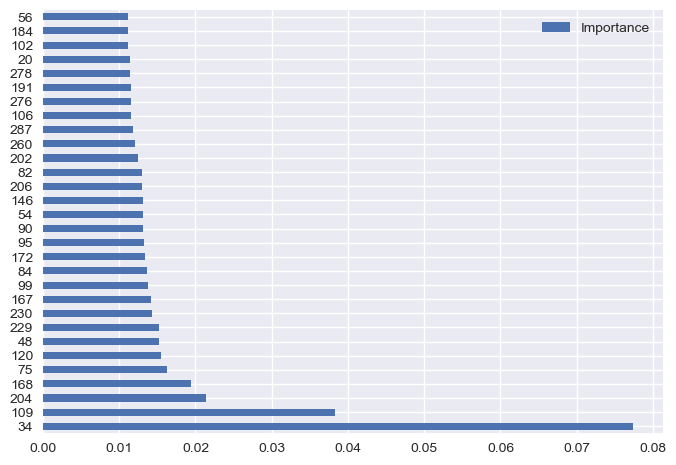

In [103]:
plt.style.use('seaborn')
importance_df[:30].plot(kind='barh');

In [97]:
model_xgb = XGBClassifier(n_estimator=300, learning_rate=0.1, n_jobs=-1, random_state=44)
model_xgb.fit(X_train_original[features_to_keep], y_train)

[06:34:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1700181161286/work/src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimator=300, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)

In [98]:
y_preds = model_xgb.predict_proba(X_test_original[features_to_keep])[:,1]
metrics.roc_auc_score(y_test, y_preds)

0.8199143755775411

In [91]:
importance_df.head(20)

,Feature,Importance
34,var_35,0.077435
109,var_110,0.038270
204,var_205,0.021419
168,var_169,0.019372
75,var_76,0.016253
120,var_121,0.015537
48,var_49,0.015217
229,var_230,0.015215
230,var_231,0.014261
167,var_168,0.014191


In [85]:
importance_df[importance_df['Feature'].isin(features_to_keep)]

,Feature,Importance
34,var_35,0.077435
109,var_110,0.038270
168,var_169,0.019372
48,var_49,0.015217
230,var_231,0.014261
45,var_46,0.009972
3,var_4,0.009571
29,var_30,0.008291
69,var_70,0.008054
81,var_82,0.007938


<BarContainer object of 20 artists>

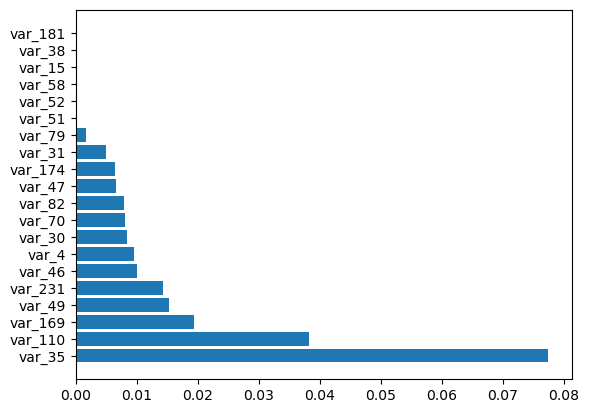

In [90]:
plt.barh(y=importance_df[importance_df['Feature'].isin(features_to_keep)]['Feature'], 
         width=importance_df[importance_df['Feature'].isin(features_to_keep)].Importance)